In [205]:
import numpy as np
import pandas as pd
import urllib3 as urllib
import urllib.request
import geopandas
import os
import choroplethNYC as cp
from censusAPI import myAPI
import requests
import io
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from fiona.crs import from_epsg


# 1. PUMA : Public Use Microdata Area

## 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [17]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [18]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

In [39]:
urllib.request.urlretrieve(url, "puma.zip")

('puma.zip', <http.client.HTTPMessage at 0x11da61eb8>)

In [41]:
!unzip puma.zip -d $PUIDATA

Archive:  puma.zip
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.dbf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.shp  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.shx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.prj  


In [42]:
!mv puma.zip $PUIDATA

In [43]:
!ls $PUIDATA

201510-citibike-tripdata.csv
201510-citibike-tripdata.zip
201511-citibike-tripdata.csv
201511-citibike-tripdata.zip
201512-citibike-tripdata.csv
201512-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.zip
201611-citibike-tripdata.csv
201611-citibike-tripdata.zip
PLUTO_for_WEB
collisions.json
geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.dbf
geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.prj
geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.shp
geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.shx
income.csv
infant_mortality.csv
nyc_pluto_18v1.zip
nycdeaths.csv
puma.gz
puma.zip
times_x8.txt


In [46]:
pumashp = geopandas.GeoDataFrame.from_file("%s/geo_export_77abfcf4-d4da-438a-9d6f-b768f4cc1c1a.shp"%os.getenv("PUIDATA"))

In [47]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [48]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2 plot the PUMA NYC regions

Text(0.5, 1.0, 'Figure 1. Map of New York City by Public Use Microdata Areas (PUMAs)')

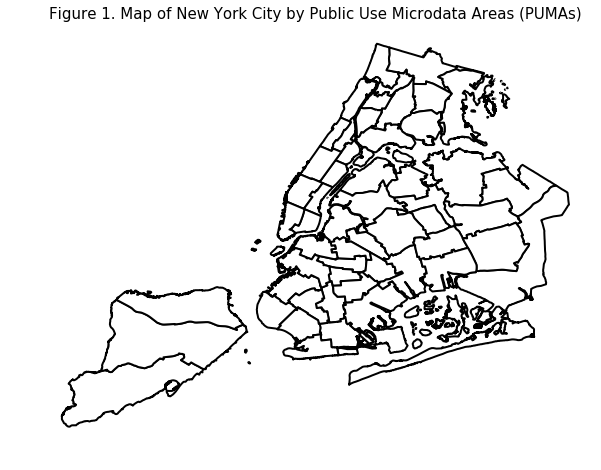

In [191]:
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2)
plt.title("Figure 1. Map of New York City by Public Use Microdata Areas (PUMAs)", fontsize=15)

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

In [61]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"

resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [67]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [68]:
affkeys

array(['for', 'in', 'B24010I_058E', ..., 'C21001G_007E', 'B11001A_004E',
       'B17020C_011E'], dtype='<U14')

In [70]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [71]:
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'label': 'Estimate!!Total',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'predicateType': 'int',
 'group': 'B28002',
 'limit': 0,
 'attributes': 'B28002_001M,B28002_001EA'}

In [72]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'predicateType': 'int',
 'group': 'B28002',
 'limit': 0,
 'attributes': 'B28002_004M,B28002_004EA'}

In [75]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [76]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [77]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']

In [78]:
pumaBB['pcBB'] = pumaBB['B28002_004E']/pumaBB['B28002_001E']*100

In [79]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [84]:
#!unzip aff_download.zip -d $PUIDATA
os.system("unzip " + puidata + "/aff_download.zip -d "+puidata)

0

In [146]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [147]:
bbpc.drop(0, inplace=True)
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc['HC01'] = bbpc['HC01'].astype(float)
bbpc['HC02'] = bbpc['HC02'].astype(float)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,01,74.7,0.5,1
2,0100100,70.9,2.5,100100
3,0100200,80.5,2.7,100200
4,0100301,87.0,2.8,100301
5,0100302,81.9,2.9,100302


In [148]:
bbpc["gid"] = bbpc.gid - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,01,74.7,0.5,-3599999
2,0100100,70.9,2.5,-3499900
3,0100200,80.5,2.7,-3499800
4,0100301,87.0,2.8,-3499699
5,0100302,81.9,2.9,-3499698


In [149]:
diff_ = pumaBB.merge(bbpc, right_on='gid', 
                     left_on='public use microdata area')[['pcBB', 'HC01']]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"])

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [153]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [154]:
#choropleth of the percentage of internet axcess
pumashp = pumashp.merge(pumaBB, right_on='public use microdata area', left_on='puma')
pumashp.head()


,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,55953,78.778618


Text(0.5, 1.0, 'Figure 1. Map of New York City colored by the percentage of households with broadband access')

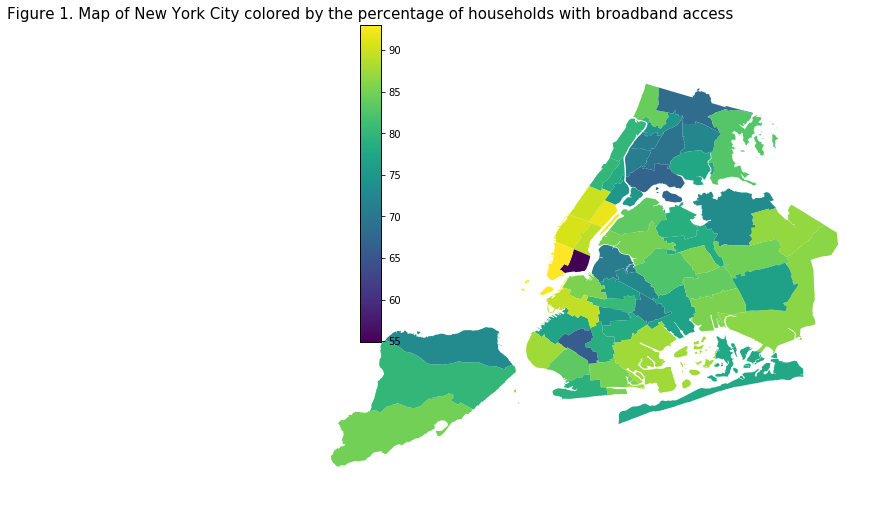

In [188]:
f, ax, cb = cp.choroplethNYC(pumashp, "pcBB", kind='continuous', cmap="viridis")
plt.title("Figure 1. Map of New York City colored by the percentage of households with broadband access", fontsize=15)


# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [160]:
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv > linkNYClocations.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75571  100 75571    0     0  82950      0 --:--:-- --:--:-- --:--:--     03      0 --:--:-- --:--:-- --:--:-- 82862


In [161]:
!mv linkNYClocations.csv $PUIDATA

In [229]:
NYClocations = pd.read_csv("%s/linkNYClocations.csv"%os.getenv("PUIDATA"),index_col=0)

In [230]:
NYClocations.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [231]:
NYClocations.shape

(1414, 4)

In [232]:
NYClocations['lonlat'] = list(zip(NYClocations.longitude, NYClocations.latitude))
NYClocations.head()

,link_site,longitude,date_link_,latitude,lonlat
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.94223923850001, 40.701930343899996)"
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [233]:
NYClocations['geometry'] = NYClocations.lonlat.map(lambda x: Point(x))
NYClocations = GeoDataFrame(NYClocations)

In [234]:
NYClocations.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.94223923850001, 40.701930343899996)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [235]:
NYClocations.crs = from_epsg(4326)

In [236]:
NYClocations.crs

{'init': 'epsg:4326', 'no_defs': True}

In [ ]:
f, ax, cb = cp.choroplethNYC(pumashp, "pcBB", kind='continuous', cmap="viridis")
plt.title("Figure 1. Map of New York City colored by the percentage of households with broadband access",fontsize=15)

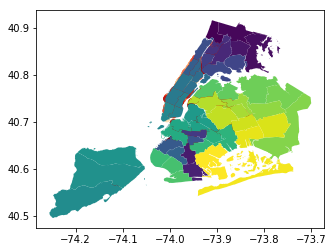

In [210]:
ax = NYClocations.plot(cmap='OrRd', scheme='quantiles')
pumashp.plot(ax=ax, cmap="viridis")

# 5. Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [197]:
keyPop = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 5.2 find the number of station per 100 people per PUMA

In [237]:
NYClocations = NYClocations.to_crs(epsg=2263)

In [238]:
NYClocations.crs

{'init': 'epsg:2263', 'no_defs': True}

In [239]:
pumashp = pumashp.to_crs(epsg=2263)

In [240]:
pumashp.crs

{'init': 'epsg:2263', 'no_defs': True}

In [308]:
link = geopandas.sjoin(NYClocations, pumashp, op='intersects').groupby('puma').count()

In [315]:
linkpp = pd.DataFrame(data=link['link_site'])

In [318]:
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19
